In [1]:
!nvidia-smi

Fri Jun 21 10:52:48 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
!unzip gdrive/My\ Drive/tomato.zip

Archive:  gdrive/My Drive/tomato.zip
replace tomato/train/Tomato___Bacterial_spot/00416648-be6e-4bd4-bc8d-82f43f8a7240___GCREC_Bact.Sp 3110.JPG? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [5]:
!ls tomato

train  val


In [6]:
train_dir = 'tomato/train/'
valid_dir = 'tomato/val/'

In [7]:
# Get the class names for our multi-class dataset
import pathlib
import numpy as np

data_dir = pathlib.Path(train_dir)
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
print(class_names)

['Tomato___Bacterial_spot' 'Tomato___Early_blight' 'Tomato___Late_blight'
 'Tomato___Leaf_Mold' 'Tomato___Septoria_leaf_spot'
 'Tomato___Spider_mites Two-spotted_spider_mite' 'Tomato___Target_Spot'
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus' 'Tomato___Tomato_mosaic_virus'
 'Tomato___healthy']


In [8]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow_hub as hub
from tensorflow.keras import layers

# Set random seed
tf.random.set_seed(42)

# Set BATCH_SIZE, IMAGE_SIZE
BATCH_SIZE = 32
IMAGE_SHAPE = (224, 224)

# Preprocess data (get all of the pixel values between 0 and 1, also called scaling/normalization)
train_datagen = ImageDataGenerator(rescale = 1./255)
valid_datagen = ImageDataGenerator(rescale = 1./255)

# Setup the train and valid directories
train_dir = 'tomato/train/'
valid_dir = 'tomato/val/'

# Import data from directories and turn into batches
train_data = train_datagen.flow_from_directory(train_dir,
                                               batch_size = BATCH_SIZE,
                                               target_size = IMAGE_SHAPE,
                                               class_mode = 'categorical',
                                               seed = 42)

valid_data = valid_datagen.flow_from_directory(valid_dir,
                                               batch_size = BATCH_SIZE,
                                               target_size = IMAGE_SHAPE,
                                               class_mode = 'categorical',
                                               seed = 42)

Found 10000 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.


In [9]:
# Create tensorboard callback (functionized because need to create a new one for each model)
import datetime
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

In [10]:
efficientnet_url = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2"

In [11]:
def create_model(model_url, num_classes=10):
  """Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.

  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in output layer,
      should be equal to number of target classes, default 10.

  Returns:
    An uncompiled Keras Sequential model with model_url as feature
    extractor layer and Dense output layer with num_classes outputs.
  """
  # Download the pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, # freeze the underlying patterns
                                           name='feature_extraction_layer',
                                           input_shape=IMAGE_SHAPE+(3,)) # define the input image shape

  # Create our own model
  model = tf.keras.Sequential([
    feature_extractor_layer, # use the feature extraction layer as the base
    layers.Dense(num_classes, activation='softmax', name='output_layer') # create our own output layer
  ])

  return model

In [12]:
# Create model
efficientnet_model = create_model(efficientnet_url, num_classes=10)

# Compile
efficientnet_model.compile(loss='categorical_crossentropy',
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=['accuracy'])

In [13]:
# Fit the model
efficientnet_history = efficientnet_model.fit(train_data,
                                              epochs=10,
                                              steps_per_epoch=len(train_data),
                                              validation_data=valid_data,
                                              validation_steps=len(valid_data),
                                              # Add TensorBoard callback to model (callbacks parameter takes a list)
                                              callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", # save experiment logs here
                                                                                     experiment_name="efficientnetv2")]) # name of log files

Saving TensorBoard log files to: tensorflow_hub/efficientnetv2/20240621-105413
Epoch 1/10
313/313 [==============================] - 41s 92ms/step - loss: 0.9752 - accuracy: 0.7303 - val_loss: 0.6041 - val_accuracy: 0.8390
Epoch 2/10
313/313 [==============================] - 27s 85ms/step - loss: 0.4858 - accuracy: 0.8709 - val_loss: 0.4579 - val_accuracy: 0.8740
Epoch 3/10
313/313 [==============================] - 27s 85ms/step - loss: 0.3711 - accuracy: 0.8998 - val_loss: 0.4027 - val_accuracy: 0.8860
Epoch 4/10
313/313 [==============================] - 26s 81ms/step - loss: 0.3101 - accuracy: 0.9174 - val_loss: 0.3552 - val_accuracy: 0.9030
Epoch 5/10
313/313 [==============================] - 25s 81ms/step - loss: 0.2675 - accuracy: 0.9271 - val_loss: 0.3486 - val_accuracy: 0.9010
Epoch 6/10
313/313 [==============================] - 27s 85ms/step - loss: 0.2388 - accuracy: 0.9337 - val_loss: 0.3169 - val_accuracy: 0.9090
Epoch 7/10
313/313 [==============================] - 29s

In [14]:
efficientnet_model.evaluate(valid_data)

32/32 [==============================] - 2s 68ms/step - loss: 0.2691 - accuracy: 0.9210


[0.26912832260131836, 0.9210000038146973]

In [15]:
# Create a function to import an image and resize it to be able to be used with our model
def load_and_prep_image(filename, img_shape = 224):
  # Read in target file(image)
  img = tf.io.read_file(filename)

  # Decode the read file into a tensor & ensure 3 colour channels
  img = tf.image.decode_image(img, channels = 3)

  # Resize the image (to the same size our model was trained on)
  img = tf.image.resize(img, size = [img_shape, img_shape])

  # Rescale the image (get all values between 0 and 1)
  img = img/255.
  return img

In [16]:
def pred_and_plot(model, filename, class_names):
  # Import the target image and preprocess it
  img = load_and_prep_image(filename)

  # Make a prediction
  pred = efficientnet_model.predict(tf.expand_dims(img, axis = 0))

  # Get the predicted class
  pred_class = class_names[pred.argmax()]

  # Plot the image and predicted class
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False);

In [17]:
import matplotlib.pyplot as plt

1/1 [==============================] - 2s 2s/step


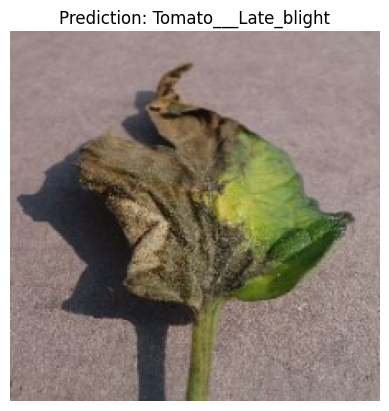

In [18]:
pred_and_plot(model = efficientnet_model, filename = '/content/tomato/val/Tomato___Late_blight/0e669afb-1315-4903-b7ca-1a0ffa95d454___RS_Late.B 5626.JPG', class_names = class_names)

1/1 [==============================] - 0s 59ms/step


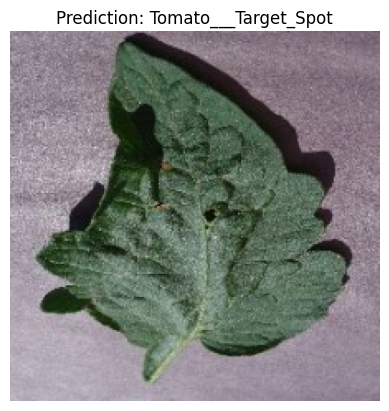

In [19]:
pred_and_plot(model = efficientnet_model, filename = '/content/tomato/val/Tomato___Target_Spot/0a2de4c5-d688-4f9d-9107-ace1d281c307___Com.G_TgS_FL 7941.JPG', class_names = class_names)

1/1 [==============================] - 0s 48ms/step


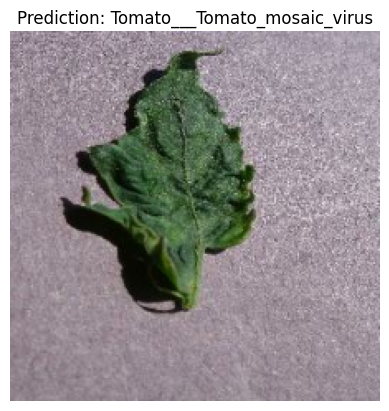

In [20]:
pred_and_plot(model = efficientnet_model, filename = '/content/tomato/val/Tomato___Tomato_mosaic_virus/0bf3eb4c-e2cd-4e72-8834-4fc045bd67ae___PSU_CG 2414.JPG', class_names = class_names)

1/1 [==============================] - 0s 56ms/step


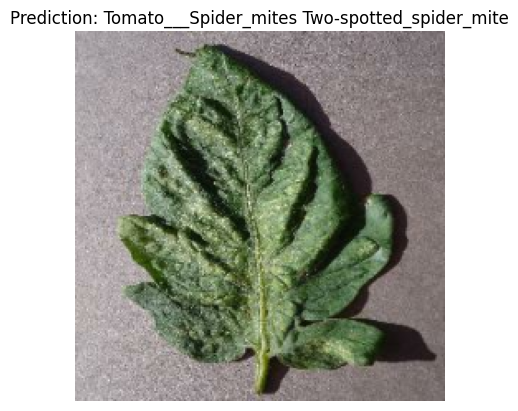

In [21]:
pred_and_plot(model = efficientnet_model, filename = '/content/tomato/val/Tomato___Spider_mites Two-spotted_spider_mite/02c791ab-ffc3-40d4-9b42-db946eee2413___Com.G_SpM_FL 1640.JPG', class_names = class_names)

In [22]:
efficientnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 1280)              5919312   
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 5932122 (22.63 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 5919312 (22.58 MB)
_________________________________________________________________


In [23]:
# Plot the validation and training data seperately
def plot_loss_curves(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot the loss
  plt.plot(epochs, loss, label = 'Training loss')
  plt.plot(epochs, val_loss, label = 'Validation loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot the accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label = 'Training accuracy')
  plt.plot(epochs, val_accuracy, label = 'Validation accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

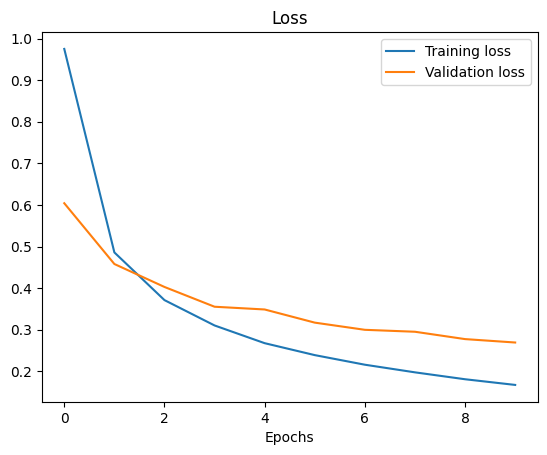

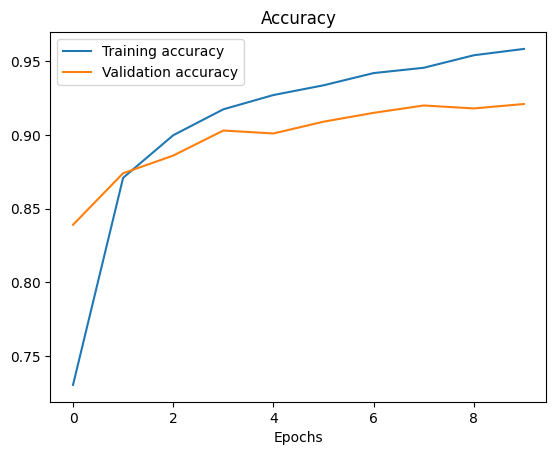

In [24]:
plot_loss_curves(efficientnet_history)

In [25]:
efficientnet_model.save("efficientnet_model_hdf5_format.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
